# Introductory practical guide to Statistics in Python

While doing research, you have, and will spend a considerable amount of time designing your experiments, executing them, and gathering data. You will then need to draw conclusions - have my experiments found something *significant*? As with everything in science, there is a particular rigour expected in data analysis, which ensures that the conclusions are made based on mathematics, probability, and the chance of your results seeming different by chance - and not demonstrating a real effect. Simply, if you want to claim something, you will often need to determine whether an action you have taken (for example, using an antibiotic, using different reaction conditions, etc.) had a real effect on the outcome of an experiment.

This course will help you build a foundation in statistical analysis using Python, which you can then use in your chemistry (and other) research. You’ll start with two-group comparisons, learning how to use t-tests and non-parametric methods to analyze differences between groups. Next, you’ll explore ANOVA for comparing multiple groups and understanding variability, and finally, tackle multiple hypothesis testing to manage more complex datasets.

## Intended learning outcomes
By the end of this course, you will be able to:

* Understand the need for statistical analysis of data 
* Do exploratory data analysis in preparation for statistical analysis
* Conduct statistical tests on simple datasets, including t-tests and ANOVA
* Apply multiple hypothesis testing to control error rates in more complex datasets
* Become confident to explore other statistical methods suited for your unique research needs

# Part 2 - ANalysis Of VAriance (ANOVA)

In this section, we will move beyond comparing two groups, and explore methods to compare *more than two groups* using Analysis of Variance (ANOVA). ANOVA helps us understand if there are significant differences between the means of multiple groups. Specifically, we will:

* Understand the purpose of ANOVA and its assumptions
* Visualize data across multiple groups
* Perform one-way ANOVA using Python to compare penguin body mass across species and sexes
* Interpret ANOVA results and checking post-hoc comparisons

### Understanding ANOVA

ANOVA, or Analysis of Variance, is a statistical method used to test if there are statistically significant differences between the means of two or more groups. For example, we could use ANOVA to test whether there are differences in body mass between different penguin species and different sexes.

The hypotheses in ANOVA are:

* Null Hypothesis (H₀): All group means are equal (no significant difference between the groups).
* Alternative Hypothesis (H₁): At least one group mean is different.

ANOVA itself will not reveal *which* groups are different from each other. To elucidate that, there are different methods, and we will look at one of them, called the Tukey's HSD (honestly significant difference) test, which does pairwise comparisons for all the groups.

**Key assumptions of ANOVA**:
1. Independence: Each group should be independent from the others.
2. Normality: The data within each group should follow a normal distribution.
3. Homogeneity of variances: The variance within each group should be similar (homoscedasticity).

When these assumptions are met, ANOVA is a powerful tool for analyzing group differences. If the assumptions are violated, alternative tests like the Kruskal-Wallis test (which is an extension of the Mann-Whitney U test used in part 1) can be used.

## Loading necessary libraries and data

We will use the [pandas library](https://pandas.pydata.org/) so we can use dataframes (a way of storing data), which are more sophisticated versions of numpy arrays and are uniquely suitable for storing data for statistical analysis and transforming large datasets. We will not go into the details of how pandas works here, but there are several [online resources](https://pandas.pydata.org/docs/getting_started/tutorials.html) if you are interested.

In [2]:
# Import numpy and matplotlib into the namespace
from pylab import *

# Import pandas
import pandas as pd

# We will be using some statistical tests implemented in scipy
import scipy.stats

# We will use matplotlib for plots
import matplotlib

## Data loading and cleaning

We will first load the data from the penguin survey from the CSV file into a pandas dataframe.

In [3]:
penguins=pd.read_csv('penguins.csv')
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


You will see that there is data missing for some penguins, with some rows showing NaN instead of a numerical value. This is quite common in many datasets, and the first task is to cleanup the dataset by removing the rows that contain no values.

In [4]:
#Remove rows that contain no values
penguins_clean = penguins.dropna()

penguins_clean

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


## Exploratory data analysis

Before running the ANOVA, let's visualize the body mass data for the different penguin species to get an initial understanding of the group differences.


                    count         mean         std     min      25%     50%  \
species_sex                                                                   
Adelie - FEMALE      73.0  3368.835616  269.380102  2850.0  3175.00  3400.0   
Adelie - MALE        73.0  4043.493151  346.811553  3325.0  3800.00  4000.0   
Chinstrap - FEMALE   34.0  3527.205882  285.333912  2700.0  3362.50  3550.0   
Chinstrap - MALE     34.0  3938.970588  362.137550  3250.0  3731.25  3950.0   
Gentoo - FEMALE      58.0  4679.741379  281.578294  3950.0  4462.50  4700.0   
Gentoo - MALE        61.0  5484.836066  313.158596  4750.0  5300.00  5500.0   

                        75%     max  
species_sex                          
Adelie - FEMALE     3550.00  3900.0  
Adelie - MALE       4300.00  4775.0  
Chinstrap - FEMALE  3693.75  4150.0  
Chinstrap - MALE    4100.00  4800.0  
Gentoo - FEMALE     4875.00  5200.0  
Gentoo - MALE       5700.00  6300.0  


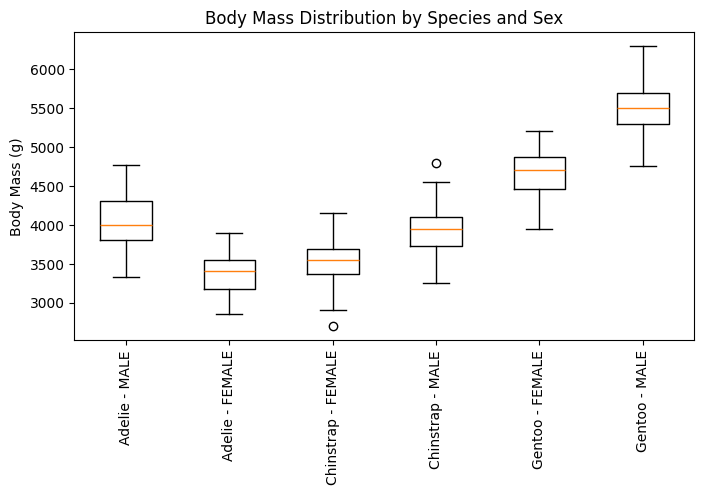

In [8]:
# Create a new interaction column 'species_sex'
penguins_clean.loc[:, 'species_sex'] = penguins_clean['species'] + " - " + penguins_clean['sex']

# Summary statistics by species
summary_stats = penguins_clean.groupby('species_sex')['body_mass_g'].describe()
print(summary_stats)

# Group the data by 'species_sex'
groups = penguins_clean.loc[:, 'species_sex'].unique()
grouped_data = [penguins_clean[penguins_clean['species_sex'] == group]['body_mass_g'].dropna() for group in groups]

# Create a boxplot using matplotlib
figure(figsize=(8, 4))
boxplot(grouped_data, tick_labels=groups)

# Customize the plot
ylabel('Body Mass (g)')
xticks(rotation=90)  # Rotate x-axis labels
title('Body Mass Distribution by Species and Sex')

# Show the plot
show()

Now lets look at the data distribution by plotting histograms

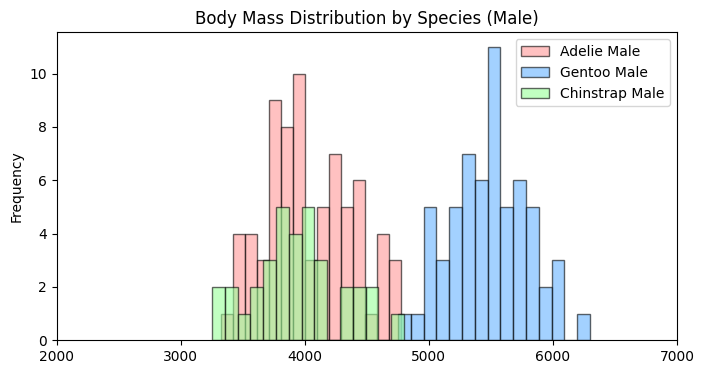

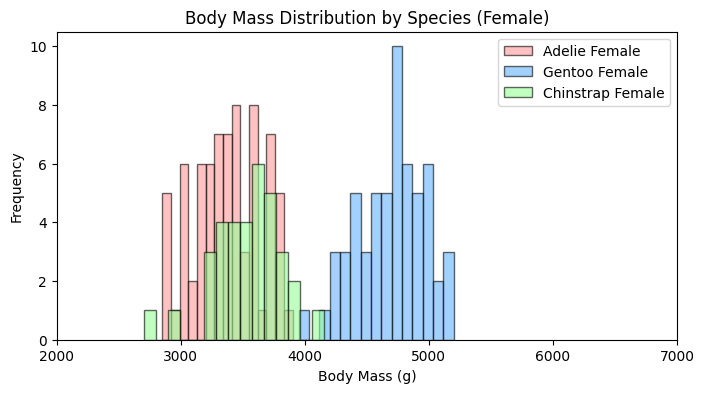

In [71]:
# Define color palette
species_colors = ['#FF9999', '#66B3FF', '#99FF99']

# Male histogram
figure(figsize=(8, 4))
hist(penguins_clean[(penguins_clean['species'] == 'Adelie') & (penguins_clean['sex'] == 'MALE')]['body_mass_g'], 
     bins=15, alpha=0.6, edgecolor='black', color=species_colors[0], label='Adelie Male')
hist(penguins_clean[(penguins_clean['species'] == 'Gentoo') & (penguins_clean['sex'] == 'MALE')]['body_mass_g'], 
     bins=15, alpha=0.6, edgecolor='black', color=species_colors[1], label='Gentoo Male')
hist(penguins_clean[(penguins_clean['species'] == 'Chinstrap') & (penguins_clean['sex'] == 'MALE')]['body_mass_g'], 
     bins=15, alpha=0.6, edgecolor='black', color=species_colors[2], label='Chinstrap Male')
title('Body Mass Distribution by Species (Male)')
ylabel('Frequency')
xlim(2000, 7000)
legend()
show()

# Female histogram
figure(figsize=(8, 4))
hist(penguins_clean[(penguins_clean['species'] == 'Adelie') & (penguins_clean['sex'] == 'FEMALE')]['body_mass_g'], 
     bins=15, alpha=0.6, edgecolor='black', color=species_colors[0], label='Adelie Female')
hist(penguins_clean[(penguins_clean['species'] == 'Gentoo') & (penguins_clean['sex'] == 'FEMALE')]['body_mass_g'], 
     bins=15, alpha=0.6, edgecolor='black', color=species_colors[1], label='Gentoo Female')
hist(penguins_clean[(penguins_clean['species'] == 'Chinstrap') & (penguins_clean['sex'] == 'FEMALE')]['body_mass_g'], 
     bins=15, alpha=0.6, edgecolor='black', color=species_colors[2], label='Chinstrap Female')
title('Body Mass Distribution by Species (Female)')
xlabel('Body Mass (g)')
ylabel('Frequency')
xlim(2000, 7000)
legend()
show()

From the plots above, we can see that the body mass distributions *look* different for some of the groups - and seem to depend both on the species, and the sex of the penguins. As in part 1, also here visual proof is not enough to say if there actually is a difference in body mass between the species and sexes. We again need to now perform formal statistical analysis on the data.

### ANOVA - data assumptions

ANOVA has the same data assumptions as the t-test. 

1. Independence of Observations: The data points in each group must be independent of each other.
2. Normality: The data in each group should be approximately normally distributed, which is especially important for small sample sizes. This can be checked using normality tests (e.g., Shapiro-Wilk test) or visually with Q-Q plots.
3. Homogeneity of Variances: The variances in all the groups should be roughly equal. This can be assessed using tests such as Levene’s test.

If assumptions 2 or 3 are not met, you should use a non-parametric test, such as the Kruskall-Wallis test.

If assumption 1 is not met, you can use the Friedmann test or use a mixed-effects model.

As with the t-test, ANOVA is preffered over non-parametric alternatives if the assumptions are met, as it provides a more efficient and reliable way to detect differences between groups.

### Checking assumptions

We use the Shapiro-Wilk test to check if the body mass data is normally distributed for each species and sex combination.


In [72]:
# Step 1: Separate the data for each species and sex
adelie_male = penguins_clean[(penguins_clean['species'] == 'Adelie') & (penguins_clean['sex'] == 'MALE')]['body_mass_g']
adelie_female = penguins_clean[(penguins_clean['species'] == 'Adelie') & (penguins_clean['sex'] == 'FEMALE')]['body_mass_g']
gentoo_male = penguins_clean[(penguins_clean['species'] == 'Gentoo') & (penguins_clean['sex'] == 'MALE')]['body_mass_g']
gentoo_female = penguins_clean[(penguins_clean['species'] == 'Gentoo') & (penguins_clean['sex'] == 'FEMALE')]['body_mass_g']
chinstrap_male = penguins_clean[(penguins_clean['species'] == 'Chinstrap') & (penguins_clean['sex'] == 'MALE')]['body_mass_g']
chinstrap_female = penguins_clean[(penguins_clean['species'] == 'Chinstrap') & (penguins_clean['sex'] == 'FEMALE')]['body_mass_g']

# Step 2: Perform the Shapiro-Wilk test on each group

# Adelie Male
adelie_male_result = scipy.stats.shapiro(adelie_male)
# Adelie Female
adelie_female_result = scipy.stats.shapiro(adelie_female)
# Gentoo Male
gentoo_male_result = scipy.stats.shapiro(gentoo_male)
# Gentoo Female
gentoo_female_result = scipy.stats.shapiro(gentoo_female)
# Chinstrap Male
chinstrap_male_result = scipy.stats.shapiro(chinstrap_male)
# Chinstrap Female
chinstrap_female_result = scipy.stats.shapiro(chinstrap_female)

# Step 3: Display the results

print(f"Adelie Male: Statistic={adelie_male_result.statistic}, p-value={adelie_male_result.pvalue}")
print(f"Adelie Female: Statistic={adelie_female_result.statistic}, p-value={adelie_female_result.pvalue}")
print(f"Gentoo Male: Statistic={gentoo_male_result.statistic}, p-value={gentoo_male_result.pvalue}")
print(f"Gentoo Female: Statistic={gentoo_female_result.statistic}, p-value={gentoo_female_result.pvalue}")
print(f"Chinstrap Male: Statistic={chinstrap_male_result.statistic}, p-value={chinstrap_male_result.pvalue}")
print(f"Chinstrap Female: Statistic={chinstrap_female_result.statistic}, p-value={chinstrap_female_result.pvalue}")

Adelie Male: Statistic=0.9826933785661867, p-value=0.4159823799821582
Adelie Female: Statistic=0.9768438275885726, p-value=0.19853027779519866
Gentoo Male: Statistic=0.9933637732832317, p-value=0.9850457287667544
Gentoo Female: Statistic=0.9813309907252777, p-value=0.5106594780473763
Chinstrap Male: Statistic=0.9841441914047142, p-value=0.8910237959486668
Chinstrap Female: Statistic=0.9634442261972539, p-value=0.30552915622247173


We use Levene’s test to check if the variances are equal between the two groups.

In [73]:
# Perform the Levene's test for equality of variances across all groups
levene_stat, levene_pvalue = scipy.stats.levene(
    adelie_male, adelie_female,
    gentoo_male, gentoo_female,
    chinstrap_male, chinstrap_female
)

# Display the Levene's test results
print(f"Levene's Test: Statistic={levene_stat}, p-value={levene_pvalue}")

Levene's Test: Statistic=1.3908258638296644, p-value=0.22721658048296609


What do we conclude?
As all the p-values for the Shapiro-Wilk tests and the Levene test are > 0.05, we can assume data for all spiecies-sex combinations is normally distributed and of equal variance. Therefore, the assumptions for ANOVA are satisfied.

### Performing ANOVA

We will now conduct a Two-Way ANOVA to examine whether body mass is influenced by both species and sex. For this, we will use the `statsmodels` package, which provides a convenient way to perform ANOVA and interpret interaction effects.

The model will test the following hypotheses:
* H₀ (for species): The mean body mass is the same for all species.
* H₀ (for sex): The mean body mass is the same for both sexes.
* H₀ (interaction): There is no interaction effect between species and sex on body mass.

The alternative hypotheses are:

* H₁ (for species): The mean body mass is different for at least two of the species.
* H₁ (for sex): The mean body mass is different for the two of the sexes.
* H₁ (interaction): There is an interaction effect between species and sex on body mass.


You might ask: What are these interaction effects?

In ANOVA, interaction effects refer to the scenario where the effect of one independent variable on the dependent variable depends on the level of another independent variable. Interaction effects help us understand whether two or more factors (independent variables) work together in a way that impacts the outcome differently than what would be expected from their individual effects alone.

In our case:
* The main effect of species would show whether different species of penguins have significantly different body masses.
* The main effect of sex would show whether male and female penguins have different body masses across all species.
* The interaction effect between species and sex would test whether the difference in body mass between males and females changes depending on the species.

If there is no interaction, this means that the difference between, say, male and female penguins’ body mass is the same across all species. In this case, the main effects tell the full story.
If there is an interaction effect, this means that the difference between male and female penguins’ body mass depends on the species. For example, the difference in body mass between male and female Gentoo penguins might be larger than between male and female Adelie penguins.

First, we must install the needed library "statsmodels". The code below will take care of that regardless of the system you are on (that's why it looks complicated).

In [74]:
import subprocess
import sys

# Function to install a package using pip
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check if statsmodels is installed, and install it if necessary
try:
    import statsmodels
except ImportError:
    print("Statsmodels not found, installing...")
    install("statsmodels")
    print("Statsmodels installed successfully!")

In [75]:
# Perform Two-Way ANOVA using statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit the two-way ANOVA model
# We are investigating whether the body mass of pengiuns depends on the species, sex, or the interaction between the two variables.
model = ols('body_mass_g ~ species + sex + species:sex', data=penguins_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
species,1.434016e+08,2.0,749.015666,8.144406e-123
sex,3.709026e+07,1.0,387.459976,1.902273e-57
species:sex,1.676557e+06,2.0,8.756997,1.973489e-04
Residual,3.130263e+07,327.0,NaN,NaN


What do the results of this test tell us?

The ANOVA table provides the p-values (PR(>F) column) for the main effects (species and sex) and their interaction. A significant p-value (< 0.05) indicates that we can reject the null hypothesis, and that the corresponding factor has a statistically significant effect on body mass.

* If both main effects are significant, we can conclude that both species and sex have an independent impact on body mass.
* If the interaction effect is significant, it suggests that the relationship between species and body mass differs depending on the sex of the penguins.

We can see that the p-values for all the 3 tested hypotheses are less than 0.05, so we reject all the null hypotheses and can now conclude:

**The mean body mass is different for at least two of the species.**

**The mean body mass is different for the two of the sexes.**

**There is an interaction effect between species and sex on body mass.**

### Which groups are different from each other?

In an ANOVA test, we may conclude that a significant difference exists between groups, but it doesn’t reveal which specific groups are different. 

To identify these differences, we use the Tukey’s Honestly Significant Difference (TukeyHSD) test, which performs pairwise comparisons between all group means.

### TukeyHSD

TukeyHSD is a post-hoc analysis that helps us find out which pairs of groups differ after we have conducted an ANOVA. It controls for the family-wise error rate, which is important when conducting multiple comparisons (as you have learned in part 2). Essentially, this test checks whether the differences between the means of any two groups are statistically significant, while maintaining a strict control over the probability of false positives.

For example, in our analysis of penguin body mass, we have identified that species and sex both have significant effects, and we now wish to compare the means across different species and between sexes to pinpoint the differences.

In [77]:
# Perform TukeyHSD test on the interaction between 'sex' and 'species'
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_interaction = pairwise_tukeyhsd(endog=penguins_clean['body_mass_g'],
                                      groups=penguins_clean['sex_species'],
                                      alpha=0.05)

# Display the results of the TukeyHSD test
print(tukey_interaction.summary())

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
      group1             group2        meandiff p-adj    lower     upper   reject
---------------------------------------------------------------------------------
   FEMALE - Adelie FEMALE - Chinstrap  158.3703 0.1376  -25.7874  342.5279  False
   FEMALE - Adelie    FEMALE - Gentoo 1310.9058    0.0 1154.8934 1466.9181   True
   FEMALE - Adelie      MALE - Adelie  674.6575    0.0  527.8486  821.4664   True
   FEMALE - Adelie   MALE - Chinstrap   570.135    0.0  385.9773  754.2926   True
   FEMALE - Adelie      MALE - Gentoo 2116.0004    0.0 1962.1408 2269.8601   True
FEMALE - Chinstrap    FEMALE - Gentoo 1152.5355    0.0  960.9603 1344.1107   True
FEMALE - Chinstrap      MALE - Adelie  516.2873    0.0  332.1296  700.4449   True
FEMALE - Chinstrap   MALE - Chinstrap  411.7647    0.0  196.6479  626.8815   True
FEMALE - Chinstrap      MALE - Gentoo 1957.6302    0.0  1767.804 2147.4564   True
   FEMALE - Gent

From this table, we can see that all spieces and sex combinations have significatnly different body mass from each other, except:

Females and Males from the Adelie species.

Females and Males from the Chinstrap species.

This concludes our analysis.

### Practice - ANOVA of Tooth Growth dataset.

In this section, you will apply what you’ve learned to a new dataset.

The Tooth Growth dataset is commonly used for teaching statistical analysis and data visualization. It contains data from a study on the effects of vitamin C on tooth growth in guinea pigs. Specifically, the dataset records the length of odontoblasts (cells responsible for tooth growth) under different conditions. There are 60 observations across three key variables:

1.	len: Odontoblast length (numeric)
2.	supp: The type of supplement used (factor with two levels: “VC” for ascorbic acid or “OJ” for orange juice)
3.	dose: The dosage of vitamin C (numeric, in milligrams per day: 0.5, 1, or 2)

The primary goal of this dataset is to explore the relationship between vitamin C dosage, the type of supplement, and tooth growth.

The dataset is stored in the toothgrowh.csv file.